In [ ]:
import string 
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline 
pd.set_option('display.max_colwidth',200)

In [ ]:
#function to read raw text file
def read_text(filename):
  file = open(filename,mode='rt',encoding ='utf-8')
  text=file.read()
  file.close()
  return text

In [ ]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [ ]:
data = read_text('/content/deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:5000,:]

In [ ]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom was shot.', 'Tom wurde erschossen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2239846 (CK) & #1544471 (Esperantostern)'],
       ['Tom was sick.', 'Tom war krank.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2239848 (CK) & #2366315 (Pfirsichbaeumchen)'],
       ['Tom was slow.', 'Tom war langsam.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6196238 (CK) & #7759409 (Neisklar)']],
      dtype='<U537')

Text to Sequence Conversion

In [ ]:
eng_1 = []
deu_1 = []

for  i in deu_eng[:,0]:
  eng_1.append(len(i.split()))

for  i in deu_eng[:,1]:
  deu_1.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_1,'deu':deu_1})

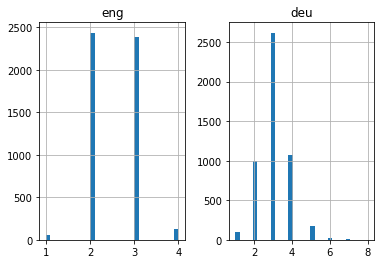

In [ ]:
length_df.hist(bins = 30)
plt.show()

In [ ]:
#function to build tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#english tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print("English Vocabulary Size:%d" % eng_vocab_size)

English Vocabulary Size:1322


In [ ]:
# prepare  Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print("Deutch Vocabulary Size:%d" % deu_vocab_size)

Deutch Vocabulary Size:2217


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer,length,lines):

  #integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)

  #pad sequences with 0 values
  seq = pad_sequences(seq,maxlen=length,padding='post')
  return seq

Model Building

In [ ]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(deu_eng , test_size = 0.2 ,random_state = 12)

In [ ]:
#preparing training data
trainX = encode_sequences(deu_tokenizer , deu_length , test[:,1])
trainY = encode_sequences(eng_tokenizer , eng_length , test[:,0])

In [ ]:
#preparing validation data
testX = encode_sequences(deu_tokenizer , deu_length , test[:,1])
testY = encode_sequences(eng_tokenizer , eng_length , test[:,0])

In [ ]:
# build NMT model
def build_model(in_vocab , out_vocab ,in_timesteps,out_timeunits):
  model = Sequential()
  model.add(Embedding(in_vocab ,units,input_length = in_timesteps ,mask_zero = True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [ ]:

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'mymodel'
checkpoint = ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0],trainY.shape[1],1), epochs=30, batch_size=512, validation_split= 0.2 ,callbacks=[checkpoint],verbose=1)


Epoch 1/30
2/2 [==============================] - 7s 4s/step - loss: 0.1489 - val_loss: 0.1537

Epoch 00001: val_loss improved from inf to 0.15369, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 2/30
2/2 [==============================] - 7s 4s/step - loss: 0.1449 - val_loss: 0.1544

Epoch 00002: val_loss did not improve from 0.15369
Epoch 3/30
2/2 [==============================] - 7s 4s/step - loss: 0.1438 - val_loss: 0.1612

Epoch 00003: val_loss did not improve from 0.15369
Epoch 4/30
2/2 [==============================] - 7s 4s/step - loss: 0.1510 - val_loss: 0.1715

Epoch 00004: val_loss did not improve from 0.15369
Epoch 5/30
2/2 [==============================] - 7s 4s/step - loss: 0.1546 - val_loss: 0.1635

Epoch 00005: val_loss did not improve from 0.15369
Epoch 6/30
2/2 [==============================] - 7s 4s/step - loss: 0.1437 - val_loss: 0.1554

Epoch 00006: val_loss did not improve from 0.15369
Epoch 7/30
2/2 [==============================] - 7s 4s/step - loss: 0.1349 - val_loss: 0.1647

Epoch 00007: val_loss did not improve from 0.15369
Epoch 8/30
2/2 [==============================] - 7s 4s/step - loss: 0.1425 - val_loss: 0.1883

Epoch 00008: val_loss 

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 11/30
2/2 [==============================] - 7s 4s/step - loss: 0.1153 - val_loss: 0.1343

Epoch 00011: val_loss improved from 0.14671 to 0.13428, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 12/30
2/2 [==============================] - 7s 4s/step - loss: 0.1024 - val_loss: 0.1306

Epoch 00012: val_loss improved from 0.13428 to 0.13063, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 13/30
2/2 [==============================] - 7s 4s/step - loss: 0.0972 - val_loss: 0.1286

Epoch 00013: val_loss improved from 0.13063 to 0.12860, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 14/30
2/2 [==============================] - 7s 4s/step - loss: 0.0935 - val_loss: 0.1275

Epoch 00014: val_loss improved from 0.12860 to 0.12755, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 15/30
2/2 [==============================] - 7s 4s/step - loss: 0.0901 - val_loss: 0.1288

Epoch 00015: val_loss did not improve from 0.12755
Epoch 16/30
2/2 [==============================] - 7s 4s/step - loss: 0.0899 - val_loss: 0.1390

Epoch 00016: val_loss did not improve from 0.12755
Epoch 17/30
2/2 [==============================] - 7s 4s/step - loss: 0.0982 - val_loss: 0.1682

Epoch 00017: val_loss did not improve from 0.12755
Epoch 18/30
2/2 [==============================] - 7s 4s/step - loss: 0.1328 - val_loss: 0.1780

Epoch 00018: val_loss did not improve from 0.12755
Epoch 19/30
2/2 [==============================] - 7s 4s/step - loss: 0.1216 - val_loss: 0.1402

Epoch 00019: val_loss did not improve from 0.12755
Epoch 20/30
2/2 [==============================] - 7s 4s/step - loss: 0.0864 - val_loss: 0.1254

Epoch 00020: val_loss improved from 0.12755 to 0.12537, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 21/30
2/2 [==============================] - 7s 4s/step - loss: 0.0733 - val_loss: 0.1224

Epoch 00021: val_loss improved from 0.12537 to 0.12241, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 22/30
2/2 [==============================] - 7s 4s/step - loss: 0.0680 - val_loss: 0.1215

Epoch 00022: val_loss improved from 0.12241 to 0.12145, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 23/30
2/2 [==============================] - 7s 4s/step - loss: 0.0652 - val_loss: 0.1206

Epoch 00023: val_loss improved from 0.12145 to 0.12055, saving model to mymodel


INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Epoch 24/30
2/2 [==============================] - 7s 4s/step - loss: 0.0626 - val_loss: 0.1214

Epoch 00024: val_loss did not improve from 0.12055
Epoch 25/30
2/2 [==============================] - 7s 4s/step - loss: 0.0621 - val_loss: 0.1243

Epoch 00025: val_loss did not improve from 0.12055
Epoch 26/30
2/2 [==============================] - 7s 4s/step - loss: 0.0643 - val_loss: 0.1377

Epoch 00026: val_loss did not improve from 0.12055
Epoch 27/30
2/2 [==============================] - 7s 4s/step - loss: 0.0807 - val_loss: 0.1841

Epoch 00027: val_loss did not improve from 0.12055
Epoch 28/30
2/2 [==============================] - 7s 4s/step - loss: 0.1099 - val_loss: 0.1703

Epoch 00028: val_loss did not improve from 0.12055
Epoch 29/30
2/2 [==============================] - 7s 4s/step - loss: 0.0890 - val_loss: 0.1280

Epoch 00029: val_loss did not improve from 0.12055
Epoch 30/30
2/2 [==============================] - 7s 4s/step - loss: 0.0557 - val_loss: 0.1222

Epoch 00030: va

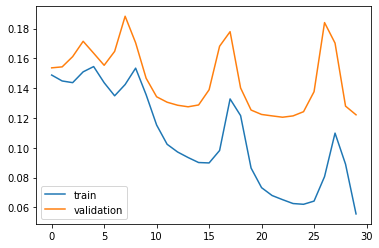

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Load the model to make predictions

In [ ]:
import numpy as np
model = load_model('mymodel')
#preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
classes_x=np.argmax(preds,axis=1)


#yhat_classes = model.predict_classes(X_test)

 #predict_x=model.predict(X_test) 
#classes_x=np.argmax(predict_x,axis=1)

In [ ]:
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    temp = list()
    for i in integers:
   	 t = word_for_id(i, tokenizer)
   	 if t is None:
   		 break
   	 temp.append(word)
    return ' '.join(temp)


In [ ]:
pred_df = pd.DataFrame({'actual':test[:,0],'predicted': predict_sequence})


In [ ]:
pd.set_option('display.max_colwidth',200)


In [ ]:
pred_df.head(15)

,actual,predicted
0,Nobody asked.,<function predict_sequence at 0x7f4196af84d0>
1,Check that.,<function predict_sequence at 0x7f4196af84d0>
2,Get away!,<function predict_sequence at 0x7f4196af84d0>
3,I'm good.,<function predict_sequence at 0x7f4196af84d0>
4,Get away!,<function predict_sequence at 0x7f4196af84d0>
5,Tom shot me.,<function predict_sequence at 0x7f4196af84d0>
6,I made it.,<function predict_sequence at 0x7f4196af84d0>
7,He dumped me.,<function predict_sequence at 0x7f4196af84d0>
8,What a dump.,<function predict_sequence at 0x7f4196af84d0>
9,Is Tom drunk?,<function predict_sequence at 0x7f4196af84d0>


In [ ]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
   	 # translate encoded source text
   	 source = source.reshape((1, source.shape[0]))
   	 translation = predict_sequence(model, eng_tokenizer, source)
   	 raw_target, raw_src = raw_dataset[i]
   	 if i < 10:
   		 print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
   	 actual.append([raw_target.split()])
   	 predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
pred_df.tail(15)

,actual,predicted
985,Help me.,<function predict_sequence at 0x7f418c625320>
986,I live here.,<function predict_sequence at 0x7f418c625320>
987,I had doubts.,<function predict_sequence at 0x7f418c625320>
988,Let me do it.,<function predict_sequence at 0x7f418c625320>
989,Stop crying.,<function predict_sequence at 0x7f418c625320>
990,Keep looking.,<function predict_sequence at 0x7f418c625320>
991,I disagreed.,<function predict_sequence at 0x7f418c625320>
992,I'm finicky.,<function predict_sequence at 0x7f418c625320>
993,Who's next?,<function predict_sequence at 0x7f418c625320>
994,Tom was nice.,<function predict_sequence at 0x7f418c625320>


In [ ]:
pred_df.head(15)

,actual,predicted
0,Nobody asked.,<function predict_sequence at 0x7f4196af84d0>
1,Check that.,<function predict_sequence at 0x7f4196af84d0>
2,Get away!,<function predict_sequence at 0x7f4196af84d0>
3,I'm good.,<function predict_sequence at 0x7f4196af84d0>
4,Get away!,<function predict_sequence at 0x7f4196af84d0>
5,Tom shot me.,<function predict_sequence at 0x7f4196af84d0>
6,I made it.,<function predict_sequence at 0x7f4196af84d0>
7,He dumped me.,<function predict_sequence at 0x7f4196af84d0>
8,What a dump.,<function predict_sequence at 0x7f4196af84d0>
9,Is Tom drunk?,<function predict_sequence at 0x7f4196af84d0>
